<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE3-MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded MLP model from /content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras
Loaded saved transformer
AdaptiveWindowAgent adaptive_window_agent initialized
Model loaded: True
Transformer fitted: True
Loading your actual dataset...
Loaded Long_train shape: (3627, 50, 12)
Testing with last 100 sequences: (100, 50, 12)

Starting real-time VAR testing...

Sample 1: Using flattened sequence of size 600
Sample   1: MLP= 2, MSE=0.0394, MAE=0.1328 Avg_MSE=0.0394

Sample 2: Using flattened sequence of size 600
Sample   2: MLP= 2, MSE=0.0053, MAE=0.0425 Avg_MSE=0.0223

Sample 3: Using flattened sequence of size 600
Sample   3: MLP= 1, MSE=0.0029, MAE=0.0438 Avg_MSE=0.0159

Sample 4: Using flattened sequence of size 600
Sample   4: MLP= 2, MSE=0.0014, MAE=0.0292 Avg_MSE=0.0122

Sample 5: Using flattened sequence of size 600
Sample   5: MLP= 2, MSE=0.0005, MAE=0.0200 Avg_MSE=0.0099

Sample 6: Using flattened sequence of size 600
Sample   6: MLP= 2, MSE=0.0015, MAE=0.0347

Sample  28: MLP= 3, MSE=0.0430, MAE=0.1226 Avg_MSE=0.1902

Sample 29: Using flattened sequence of size 600
Sample  29: MLP= 2, MSE=0.0996, MAE=0.2213 Avg_MSE=0.2001
*** DRIFT DETECTED at sample 29 ***

Sample 30: Using flattened sequence of size 600
Sample  30: MLP= 1, MSE=0.1912, MAE=0.3800 Avg_MSE=0.2189

Sample 31: Using flattened sequence of size 600
Sample  31: MLP= 3, MSE=0.1309, MAE=0.3053 Avg_MSE=0.2292

Sample 32: Using flattened sequence of size 600
Sample  32: MLP= 3, MSE=0.0847, MAE=0.2286 Avg_MSE=0.2374

Sample 33: Using flattened sequence of size 600
Sample  33: MLP= 3, MSE=0.0127, MAE=0.0965 Avg_MSE=0.2385

Sample 34: Using flattened sequence of size 600


Sample  34: MLP= 4, MSE=0.0403, MAE=0.1547 Avg_MSE=0.2424
*** DRIFT DETECTED at sample 34 ***

Sample 35: Using flattened sequence of size 600
Sample  35: MLP= 2, MSE=0.0012, MAE=0.0300 Avg_MSE=0.2385

Sample 36: Using flattened sequence of size 600
Sample  36: MLP= 2, MSE=0.0050, MAE=0.0557 Avg_MSE=0.2277
*** ANOMALY DETECTED at sample 36 ***

Sample 37: Using flattened sequence of size 600
Sample  37: MLP= 2, MSE=0.0090, MAE=0.0546 Avg_MSE=0.0618

Sample 38: Using flattened sequence of size 600
Sample  38: MLP= 2, MSE=0.0152, MAE=0.0820 Avg_MSE=0.0590

Sample 39: Using flattened sequence of size 600
Sample  39: MLP= 1, MSE=0.0067, MAE=0.0526 Avg_MSE=0.0497

Sample 40: Using flattened sequence of size 600
Sample  40: MLP= 0, MSE=0.0047, MAE=0.0436 Avg_MSE=0.0310

Sample 41: Using flattened sequence of size 600
Sample  41: MLP= 1, MSE=0.0064, MAE=0.0586 Avg_MSE=0.0186

Sample 42: Using flattened sequence of size 600
Sample  42: MLP= 1, MSE=0.0023, MAE=0.0416 Avg_MSE=0.0103

Sample 43: 

Sample  97: MLP= 2, MSE=0.0001, MAE=0.0088 Avg_MSE=0.7146

Sample 98: Using flattened sequence of size 600
Sample  98: MLP= 3, MSE=0.6170, MAE=0.6223 Avg_MSE=0.7761
*** DRIFT DETECTED at sample 98 ***

Sample 99: Using flattened sequence of size 600
Sample  99: MLP= 2, MSE=0.6190, MAE=0.6161 Avg_MSE=0.8379

Sample 100: Using flattened sequence of size 600
Sample 100: MLP= 4, MSE=0.4159, MAE=0.5046 Avg_MSE=0.8791

FINAL PERFORMANCE SUMMARY
Total predictions: 100
Successful predictions: 50
Success rate: 50.00%
Average MSE: 0.8791
Average MAE: 0.5752
Anomaly events: 1
Drift events: 3
Retraining events: 0
Transformer fitted: True


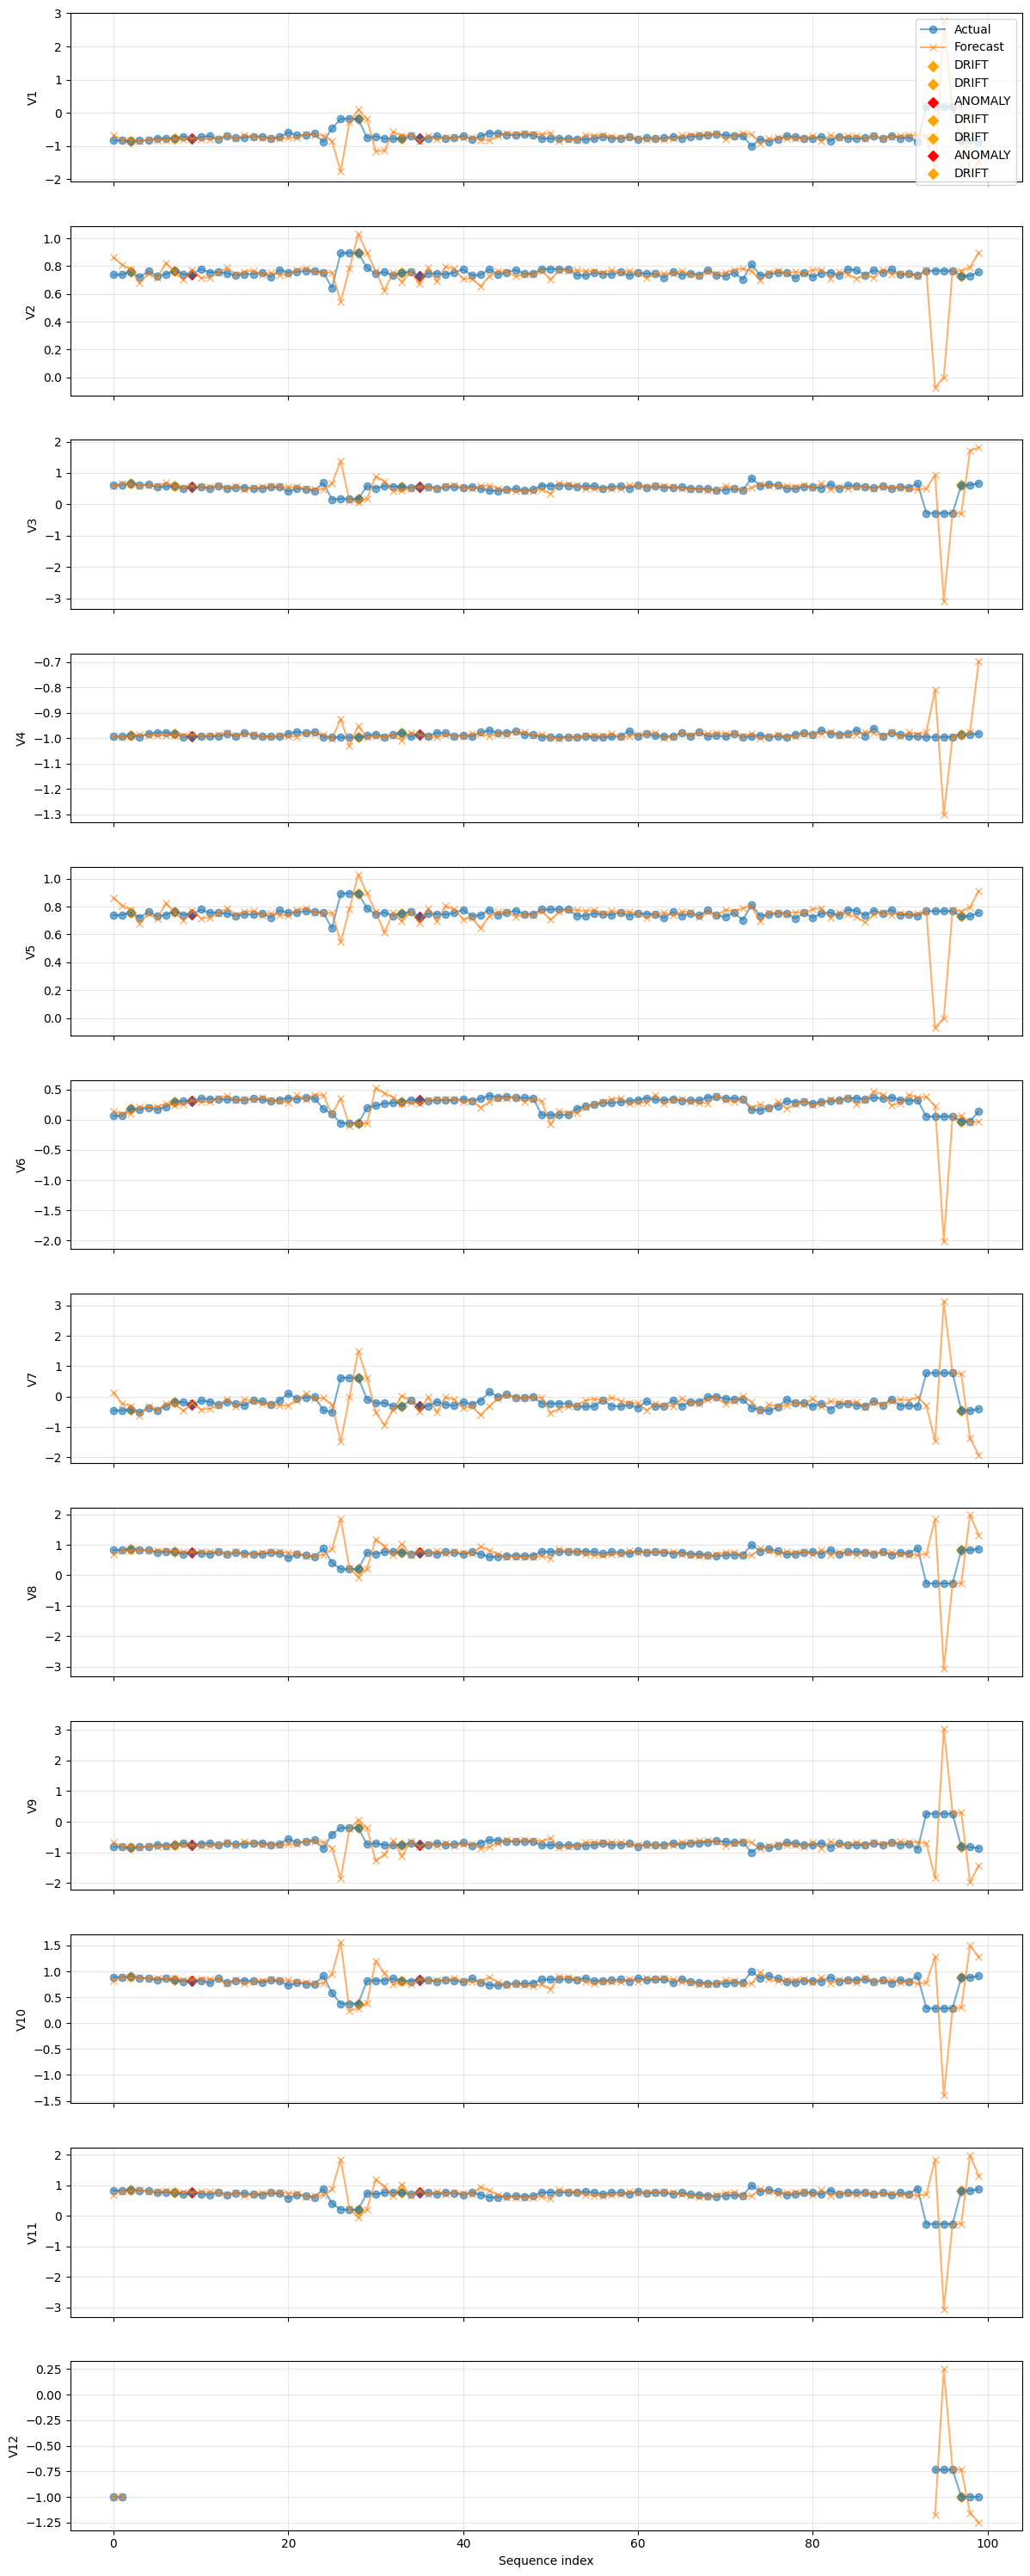


Test results saved to: real_data_test_results.json


In [20]:
# agents/adaptive_window_agent.py
import numpy as np
import pandas as pd
import pickle
import json
import os
from collections import deque
from typing import Dict, Any
import datetime as dt
import logging
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

logger = logging.getLogger(__name__)

class AdaptiveWindowAgent:
    """
    Agent A: Adaptive Window Management with Enhanced MLP

    Capabilities:
    1. Predict window size using trained MLP
    2. Calculate actual performance using VAR forecast
    3. Track accuracy and performance statistics
    4. Monitor for anomaly vs drift in prediction performance
    5. Retrain MLP when drift is confirmed
    """

    def __init__(self, agent_id: str = "adaptive_window_agent",
                 model_path: str = None,
                 checkpoint_path: str = None):
        self.agent_id = agent_id
        self.model_path = model_path or "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
        self.checkpoint_path = checkpoint_path or "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/ckp2.weights.h5"

        # Core MLP
        self.model = None
        self.transformer = StandardScaler()
        self.transformer_fitted = False
        self.is_model_loaded = False

        # Performance tracking
        self.prediction_history = deque(maxlen=1000)
        self.mse_history = deque(maxlen=200)
        self.mae_history = deque(maxlen=200)

        # Event detection parameters
        self.drift_detection_window = 20
        self.drift_threshold_mse = 0.2
        self.drift_threshold_mae = 0.2
        self.consecutive_poor_predictions = 0
        self.cooldown_counter = 0

        # Stats
        self.performance_stats = {
            'total_predictions': 0,
            'avg_mse': 0.0,
            'avg_mae': 0.0,
            'last_retrain_time': None,
            'drift_events': 0,
            'anomaly_events': 0,
            'retraining_events': 0
        }

        # Buffers for retraining
        self.retraining_data = {
            'x_buffer': deque(maxlen=10000),
            'y_buffer': deque(maxlen=10000)
        }

        self.load_model()
        print(f"AdaptiveWindowAgent {self.agent_id} initialized")
        print(f"Model loaded: {self.is_model_loaded}")
        print(f"Transformer fitted: {self.transformer_fitted}")

    def load_model(self):
        """Load trained MLP model and recreate transformer"""
        try:
            if os.path.exists(self.model_path):
                self.model = keras.models.load_model(self.model_path)
                self.is_model_loaded = True
                print(f"Loaded MLP model from {self.model_path}")

                transformer_path = self.model_path.replace('.keras', '_transformer.pkl')
                if os.path.exists(transformer_path):
                    with open(transformer_path, 'rb') as f:
                        self.transformer = pickle.load(f)
                    self.transformer_fitted = True
                    print("Loaded saved transformer")
                else:
                    y_original = np.load('/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy')
                    self.transformer = StandardScaler()
                    self.transformer.fit(y_original.reshape(-1, 1))
                    self.transformer_fitted = True
                    with open(transformer_path, 'wb') as f:
                        pickle.dump(self.transformer, f)
                    print(f"Fitted transformer on {len(y_original)} samples and saved")
            else:
                print(f"Model file not found at {self.model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")

    def evaluate_forecast_performance(self, sequence_3d: np.ndarray, predicted_window: int, n_future: int = 1) -> Dict[str, float]:
        """Use predicted window to forecast with VAR and calculate MSE/MAE"""
        try:
            df = pd.DataFrame(sequence_3d, columns=[f'V{i+1}' for i in range(sequence_3d.shape[1])])
            df_train, df_test = df[0:-n_future], df[-n_future:]

            # Drop constant columns
            constant_columns = [col for col in df_train.columns if df_train[col].nunique() <= 1 or df_train[col].var() < 1e-12]
            df_train = df_train.drop(columns=constant_columns, errors="ignore")
            df_test = df_test.drop(columns=constant_columns, errors="ignore")

            if len(df_train.columns) < 2:
                return {'mse': 99999, 'mae': 99999, 'forecast_success': False}

            k = min(predicted_window, len(df_train) - 2)
            if k < 1: k = 1

            model = VAR(df_train)
            model_fitted = None
            for trend in ['n', 'c', 'ct', 'ctt']:
                try:
                    model_fitted = model.fit(maxlags=k, trend=trend)
                    break
                except:
                    continue
            if model_fitted is None:
                return {'mse': 99999, 'mae': 99999, 'forecast_success': False}

            forecast_input = df_train.values[-model_fitted.k_ar:]
            fc = model_fitted.forecast(y=forecast_input, steps=n_future)
            df_forecast = pd.DataFrame(fc, index=df.index[-n_future:], columns=df_train.columns)

            common_cols = [c for c in df_forecast.columns if c in df_test.columns]
            actual = df_test[common_cols].values.flatten()
            predicted = df_forecast[common_cols].values.flatten()

            mse = np.mean((actual - predicted) ** 2)
            mae = np.mean(np.abs(actual - predicted))

            return {
                'mse': float(mse),
                'mae': float(mae),
                'forecast_success': True,
                'used_columns': common_cols,
                'actual_values': actual.tolist(),
                'predicted_values': predicted.tolist()
            }
        except Exception as e:
            return {'mse': 99999, 'mae': 99999, 'forecast_success': False, 'error': str(e)}

    def predict_window_size(self, feature_vector: np.ndarray, sequence_3d: np.ndarray) -> Dict[str, Any]:
        """Predict window size using MLP and evaluate forecast"""
        if not self.is_model_loaded:
            return {'predicted_window': 20, 'confidence': 0.0, 'error': "Model not loaded"}
        try:
            if feature_vector.ndim == 1:
                feature_vector = feature_vector.reshape(1, -1)

            prediction_raw = self.model.predict(feature_vector, verbose=0)
            if self.transformer_fitted:
                predicted_window = self.transformer.inverse_transform(prediction_raw)[0, 0]
            else:
                predicted_window = prediction_raw[0, 0]
            predicted_window = int(round(predicted_window))

            forecast_metrics = self.evaluate_forecast_performance(sequence_3d, predicted_window, n_future=1)

            prediction_record = {
                'timestamp': dt.datetime.now(),
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'forecast_success': forecast_metrics.get('forecast_success', False)
            }

            if forecast_metrics.get('forecast_success', False):
                self.mse_history.append(forecast_metrics['mse'])
                self.mae_history.append(forecast_metrics['mae'])
                self.performance_stats['total_predictions'] += 1
                self.performance_stats['avg_mse'] = np.mean(self.mse_history)
                self.performance_stats['avg_mae'] = np.mean(self.mae_history)

                event_type = self._check_for_event()
                prediction_record['event_type'] = event_type
            else:
                self.consecutive_poor_predictions += 1
                prediction_record['event_type'] = None

            self.prediction_history.append(prediction_record)
            self.retraining_data['x_buffer'].append(feature_vector.flatten())
            self.retraining_data['y_buffer'].append(predicted_window)

            return {
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'confidence': self._calculate_confidence(prediction_record),
                'performance_stats': self.get_recent_performance(),
                'event_type': prediction_record['event_type'],
                'prediction_id': len(self.prediction_history)
            }
        except Exception as e:
            return {'predicted_window': 20, 'confidence': 0.0, 'error': str(e)}

    def _check_for_event(self) -> str:
        """Detect anomaly vs drift using persistence and error spread."""
        if len(self.mse_history) < self.drift_detection_window:
            return None
        try:
            def ema(values, alpha=0.3):
                ema_val = values[0]
                for v in values[1:]:
                    ema_val = alpha * v + (1 - alpha) * ema_val
                return ema_val

            mse_vals = list(self.mse_history)[-self.drift_detection_window:]
            mae_vals = list(self.mae_history)[-self.drift_detection_window:]
            ema_mse, ema_mae = ema(mse_vals), ema(mae_vals)
            baseline_mse, baseline_mae = np.median(mse_vals), np.median(mae_vals)

            mse_ratio = ema_mse / max(baseline_mse, 1e-5)
            mae_ratio = ema_mae / max(baseline_mae, 1e-5)

            # Absolute thresholds
            if ema_mse < 0.02 and ema_mae < 0.08:
                self.consecutive_poor_predictions = 0
                return None

            event_condition = (mse_ratio > (1 + self.drift_threshold_mse) and
                               mae_ratio > (1 + self.drift_threshold_mae))

            if event_condition:
                self.consecutive_poor_predictions += 1
            else:
                if 0 < self.consecutive_poor_predictions < 3:
                    self.performance_stats['anomaly_events'] += 1
                    logger.warning(f"ANOMALY detected: EMA_MSE={ema_mse:.4f}, EMA_MAE={ema_mae:.4f}")
                    self.consecutive_poor_predictions = 0
                    return "ANOMALY"
                self.consecutive_poor_predictions = 0

            if self.consecutive_poor_predictions >= 5:
                self.performance_stats['drift_events'] += 1
                logger.warning(f"DRIFT detected: MSE ratio={mse_ratio:.3f}, MAE ratio={mae_ratio:.3f}, "
                               f"EMA_MSE={ema_mse:.4f}, EMA_MAE={ema_mae:.4f}")
                self.consecutive_poor_predictions = 0
                return "DRIFT"

            return None
        except Exception as e:
            logger.error(f"Event detection error: {e}")
            return None

    def _calculate_confidence(self, prediction_record: Dict) -> float:
        if len(self.mse_history) < 10: return 0.5
        recent_mse = np.mean(list(self.mse_history)[-10:])
        recent_mae = np.mean(list(self.mae_history)[-10:])
        mse_conf = max(0, 1 - (recent_mse / (np.percentile(list(self.mse_history), 25) * 4)))
        mae_conf = max(0, 1 - (recent_mae / (np.percentile(list(self.mae_history), 25) * 4)))
        return min(1.0, max(0.1, (mse_conf + mae_conf) / 2))

    def get_recent_performance(self) -> Dict[str, Any]:
        successful_predictions = [p for p in list(self.prediction_history)[-50:] if p.get('forecast_success', False)]
        return {
            'total_predictions': len(self.prediction_history),
            'successful_predictions': len(successful_predictions),
            'success_rate': len(successful_predictions) / max(len(self.prediction_history), 1),
            'drift_events': self.performance_stats['drift_events'],
            'anomaly_events': self.performance_stats['anomaly_events'],
            'retraining_events': self.performance_stats['retraining_events'],
            'recent_mse': np.mean(list(self.mse_history)[-10:]) if self.mse_history else 0,
            'avg_mse': np.mean(self.mse_history) if self.mse_history else 0,
            'recent_mae': np.mean(list(self.mae_history)[-10:]) if self.mae_history else 0,
            'avg_mae': np.mean(self.mae_history) if self.mae_history else 0,
            'transformer_fitted': self.transformer_fitted
        }

    def save_performance_state(self, filepath: str):
        state = {
            'performance_stats': self.performance_stats.copy(),
            'prediction_history': list(self.prediction_history)[-100:],
            'mse_history': list(self.mse_history),
            'mae_history': list(self.mae_history),
            'transformer_fitted': self.transformer_fitted
        }
        with open(filepath, 'w') as f:
            json.dump(state, f, default=str, indent=2)


# ==================== PLOTTING ====================
import matplotlib.pyplot as plt

def plot_all_features_forecasts(test_sequences, agent, max_features=12):
    all_actual, all_forecast, event_points = [], [], []
    for i, seq in enumerate(test_sequences):
        result = agent.predict_window_size(seq.flatten(), seq)
        fm = result.get("forecast_metrics", {})
        if not fm.get("forecast_success", False): continue
        actual_row = [np.nan] * max_features
        forecast_row = [np.nan] * max_features
        for j, col in enumerate(fm.get("used_columns", [])):
            idx = int(col.replace("V", "")) - 1
            if idx < max_features:
                actual_row[idx] = fm["actual_values"][j]
                forecast_row[idx] = fm["predicted_values"][j]
        all_actual.append(actual_row)
        all_forecast.append(forecast_row)
        if result.get("event_type", None):
            event_points.append((i, result["event_type"]))
    if not all_actual: return
    actual_matrix = np.array(all_actual)
    forecast_matrix = np.array(all_forecast)
    timestamps = np.arange(len(actual_matrix))
    fig, axes = plt.subplots(max_features, 1, figsize=(12, 2.5 * max_features), sharex=True)
    for idx, ax in enumerate(axes):
        ax.plot(timestamps, actual_matrix[:, idx], label="Actual", marker="o", alpha=0.6)
        ax.plot(timestamps, forecast_matrix[:, idx], label="Forecast", marker="x", alpha=0.6)
        for (t, etype) in event_points:
            ax.scatter(t, actual_matrix[t, idx], color="red" if etype=="ANOMALY" else "orange",
                       marker="D", label=etype if idx==0 else "")
        ax.set_ylabel(f"V{idx+1}"); ax.grid(True, alpha=0.3)
        if idx == 0: ax.legend()
    axes[-1].set_xlabel("Sequence index")
    plt.tight_layout(); plt.show()

# ==================== MAIN TEST LOOP ====================
if __name__ == "__main__":
    # Initialize the agent
    agent = AdaptiveWindowAgent(
        model_path="/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
    )

    print("Loading your actual dataset...")
    Long_train = np.load('/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy')
    print(f"Loaded Long_train shape: {Long_train.shape}")

    # Last 100 sequences for test
    test_sequences = Long_train[-100:]
    print(f"Testing with last {len(test_sequences)} sequences: {test_sequences.shape}")

    print("\nStarting real-time VAR testing...")
    print("=" * 70)

    for i, sequence_3d in enumerate(test_sequences, start=1):
        features = sequence_3d.flatten()
        print(f"\nSample {i}: Using flattened sequence of size {len(features)}")

        result = agent.predict_window_size(features, sequence_3d=sequence_3d)
        forecast_metrics = result.get('forecast_metrics', {})
        event_type = result.get('event_type', None)
        error_msg = result.get('error', None)

        if error_msg:
            print(f"Sample {i}: ERROR - {error_msg}")
            continue

        if forecast_metrics.get('forecast_success', False):
            mse_val = forecast_metrics['mse']
            mae_val = forecast_metrics['mae']
            mlp_pred = result.get('predicted_window', 0)
            performance = agent.get_recent_performance()

            print(f"Sample {i:3d}: MLP={mlp_pred:2d}, "
                  f"MSE={mse_val:6.4f}, MAE={mae_val:6.4f} "
                  f"Avg_MSE={performance.get('recent_mse', 0):6.4f}")

            if event_type:
                print(f"*** {event_type.upper()} DETECTED at sample {i} ***")

        else:
            print(f"Sample {i:3d}: VAR forecast failed")

    print("\n" + "=" * 70)
    print("FINAL PERFORMANCE SUMMARY")
    print("=" * 70)

    final_perf = agent.get_recent_performance()
    print(f"Total predictions: {final_perf.get('total_predictions', 0)}")
    print(f"Successful predictions: {final_perf.get('successful_predictions', 0)}")
    print(f"Success rate: {final_perf.get('success_rate', 0):.2%}")
    print(f"Average MSE: {final_perf.get('recent_mse', 0):.4f}")
    print(f"Average MAE: {final_perf.get('recent_mae', 0):.4f}")
    print(f"Anomaly events: {final_perf.get('anomaly_events', 0)}")
    print(f"Drift events: {final_perf.get('drift_events', 0)}")
    print(f"Retraining events: {final_perf.get('retraining_events', 0)}")
    print(f"Transformer fitted: {final_perf.get('transformer_fitted', False)}")

    plot_all_features_forecasts(test_sequences, agent, max_features=12)

    agent.save_performance_state("real_data_test_results.json")
    print(f"\nTest results saved to: real_data_test_results.json")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')